In [1]:
!nvidia-smi

Mon Mar 21 08:32:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [4]:
# 오토인코더 : 어떤 지도 없이도 잠재표현 또는 코딩이라 부르는 입력 데이터의 밀집 표현을 학습할 수 있는 인공 신경망
# GAN : 생성적 적대 신경망

# 오토인코더는 항상 두부분으로 구성. 입력을 내부표현으로 바꾸는 인코더(인지 네트워크)와 내부표현을 출력으로 바꾸는 디코더(생성 네크워크)
# 일반적으로 오토인코더는 다층 퍼셉트론과 구조 동일
# 내부의 표현이 입력 데이터보다 저차원이기 때문에 과소완전이라고 함

## 과소완전 선형 오토인코더로 PCA 수행

In [4]:
# 오토인코터가 선형 활성화 함수만 사용하고 비용 함수가 평균 제곱 오차라면 결국 주성분 분석을 수행하는 것으로 볼 수 있음

# 3D 데이터셋에 PCA를 적용해 2D에 투영하는 간단한 선형 오토인코더
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 3s 14ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 14ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 15ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 16ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 9ms/step - lo

In [7]:
codings = encoder.predict(X_train)

그림 저장 linear_autoencoder_pca_plot


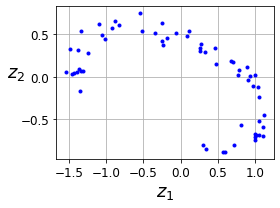

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## 적층 오토인코더

In [9]:
# 적층 오코인코더 (심층 오토인코더): 은닉층 여러개
# 전형적으로 가운데 은닉층 기준으로 대칭

# 케라스를 사용하여 적층 오토인코더 구현
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 11s 5ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3163 - val_rounded_accuracy: 0.9008
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2986 - rounded_accuracy: 0.9216 - val_loss: 0.2985 - val_rounded_accuracy: 0.9199
Epoch 4/20
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==============

그림 저장 reconstruction_plot


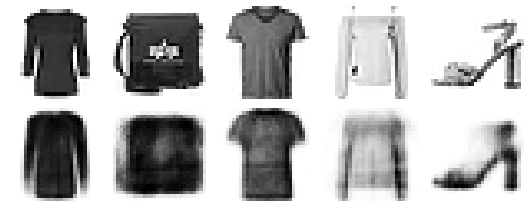

In [12]:
# 재구성 시각화
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

In [13]:
# 패션 MNIST 데이터셋 시각화
# 다른 차원 축소 알고리즘만큼 좋은 결과를 주지 못하지만 오토인코더의 장점은 샘플과 특성이 많은 대용량 데이터셋을 다를 수 있음
# 오토인코더를 사용해 적절한 수준으로 차원을 축소한 후 다른 차원 축소 알고리즘을 사용해 시각화 하는 것도 전략
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


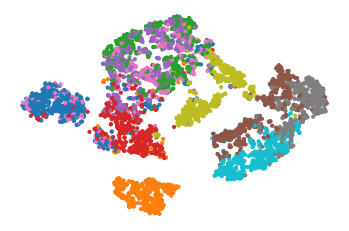

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

그림 저장 fashion_mnist_visualization_plot


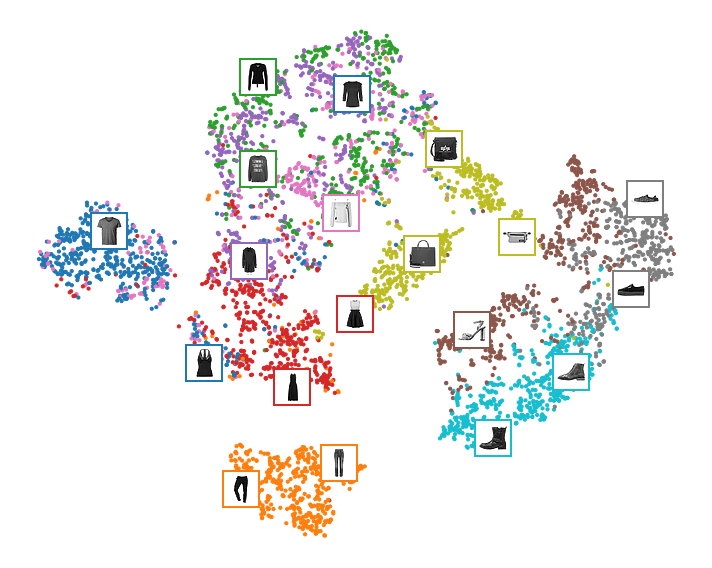

In [15]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

In [16]:
# 가중치 묶기
# 인코더의 가중치를 전치하여서 디코더의 가중치로 사용하는 식으로 인코더와 디코더의 가중치를 묶는 일은 흔하다
# 이렇게 하려면 사용자 정의 층을 사용해야함
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3082 - val_rounded_accuracy: 0.9076
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2952 - val_rounded_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3017 - val_rounded_accuracy: 0.9088
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2865 - rounded_accuracy: 0.9324 - val_loss: 0.2872 - val_rounded_accuracy: 0.9319
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==============

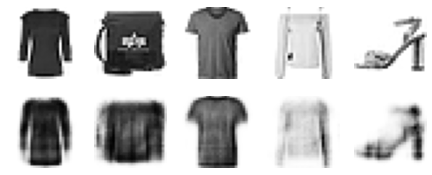

In [18]:
show_reconstructions(tied_ae)
plt.show()

In [19]:
# 한번에 오토인코더 한개씩 훈련
# 탐욕적 방식의 층별 훈련 :한번에 전체 오토인코더를 훈련하는 것보다 오토인코더 하나를 훈련하고 이를 쌓아올려서 한개의 적층 오토인코더를 만듦
# 첫번째 오토인코더는 입력 재구성하도록 학습
# 첫번째 인코더로 인코딩된 훈련 세트를 두번째 오토인코더에서 훈련
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [=============

In [21]:
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5620 - val_loss: 0.3439
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2612 - val_loss: 0.2369
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2253 - val_loss: 0.2174
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2109 - val_loss: 0.2058
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2035 - val_loss: 0.1973
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1987 - val_loss: 0.1978
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1971 - val_loss: 0.1999
Epoch 8/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1955 - val_loss: 0.2001
Epoch 9/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1949 - val_loss: 0.1932
Epoch 10/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.194

In [22]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

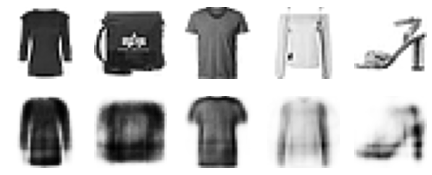

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9350
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [=============

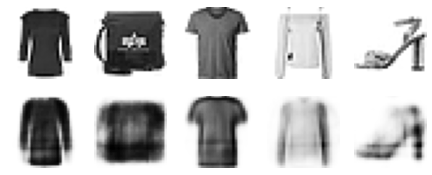

In [25]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [26]:
# 합성곱 오토인코더
# 이미지는 합성곱 신경망이 성능이 좋음
# 3개의 은닉층과 1개의 출력층 (두개의 적층)을 가진 적층 오토인코더

tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 21s 8ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2850 - val_rounded_accuracy: 0.9283
Epoch 2/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2730 - val_rounded_accuracy: 0.9451
Epoch 3/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2684 - val_rounded_accuracy: 0.9493
Epoch 5/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2673 - val_rounded_accuracy: 0.9505


In [27]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

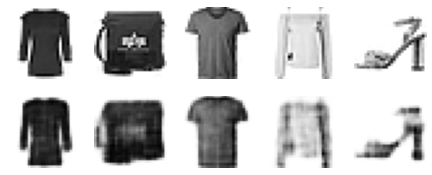

In [28]:
show_reconstructions(conv_ae)
plt.show()

In [29]:
# 순환 오토인코더
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [30]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 56s 29ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 52s 30ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3743 - val_rounded_accuracy: 0.8678
Epoch 3/10
1719/1719 [==============================] - 52s 31ms/step - loss: 0.3653 - rounded_accuracy: 0.8711 - val_loss: 0.3603 - val_rounded_accuracy: 0.8767
Epoch 4/10
1719/1719 [==============================] - 53s 31ms/step - loss: 0.3508 - rounded_accuracy: 0.8809 - val_loss: 0.3524 - val_rounded_accuracy: 0.8772
Epoch 5/10
1719/1719 [==============================] - 53s 31ms/step - loss: 0.3406 - rounded_accuracy: 0.8875 - val_loss: 0.3362 - val_rounded_accuracy: 0.8919
Epoch 6/10
1719/1719 [==============================] - 54s 31ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3305 - val_rounded_accuracy: 0.8964
Epoch 7/10
1719/1719 [======

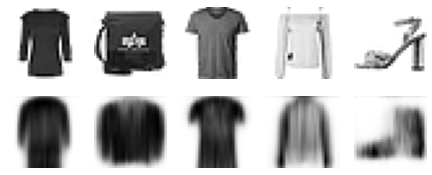

In [31]:
show_reconstructions(recurrent_ae)
plt.show()

In [32]:
# 적층 잡음 제거 오토인코더
# 오토인코더가 유용한 특성을 학습하도록 강제하는 다른 방법 : 입력에 잡음 추가하고 잡음이 없는 원본 입력을 복원하도록 훈련하는 것
# 잡음은 입력에 추가된 순수한 가우시안 잡음이거나 드롭아웃처럼 무작위로 입력을 꺼서 발생시킬 수 있음

# 가우시안 노이즈
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9237
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [==================

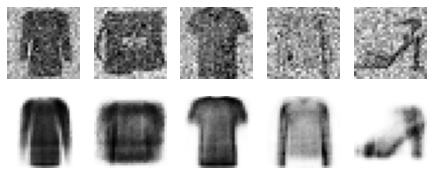

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [34]:
# 드롭아웃
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [============

그림 저장 dropout_denoising_plot


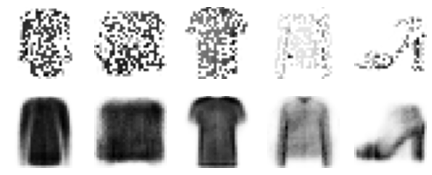

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

In [38]:
# 희소 오토인코더
# 좋은 특성을 추출하도록 만드는 제약의 방식 중 하나는 희소 sparsity
# 비용 함수에 적절한 항을 추가해서 인토인코더가 코딩층에 활성화되는 뉴런 수를 감소시키도록 만듦
# 방법 : 코딩 층에 시그모이드 활성화 함수를 사용하고 큰 코딩 층을 사용하는 것, 코딩 층의 활성화 값에 L1 규제 추가

tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8992
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3213 - rounded_accuracy: 0.9012 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

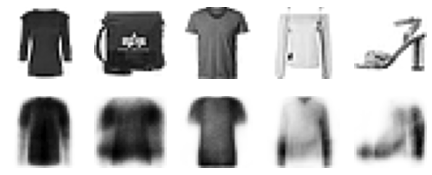

In [39]:
show_reconstructions(simple_ae)
plt.show()

In [40]:
def plot_percent_hist(ax, data, bins):
  counts, _ = np.histogram(data, bins=bins)
  widths = bins[1:] - bins[:-1]
  x = bins[:-1] + widths / 2
  ax.bar(x, counts / len(data), width=widths*0.8)
  ax.xaxis.set_ticks(bins)
  ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
      lambda y, position: "{}%".format(int(np.round(100 * y)))))
  ax.grid(True)

In [43]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

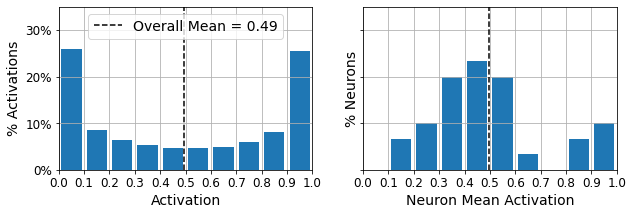

In [44]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()
# 왼쪽 히스토그램 전체 활성화의 분포, 0과 1에 가까운 값에 많이 등장하는 것은 시그모이드 함수가 포화되는 특성때문
# 오른쪽 평균 뉴런의 분포

In [46]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
                                             keras.layers.Flatten(input_shape=[28, 28]),
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(300, activation="sigmoid"),
                                             keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
                                             keras.layers.Dense(100, activation="selu", input_shape=[300]),
                                             keras.layers.Dense(28 * 28, activation="sigmoid"),
                                             keras.layers.Reshape([28, 28])                                            
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==============

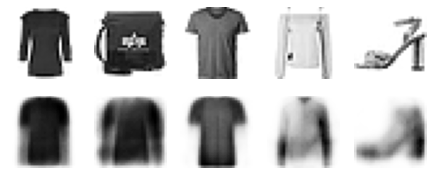

In [47]:
show_reconstructions(sparse_l1_ae)

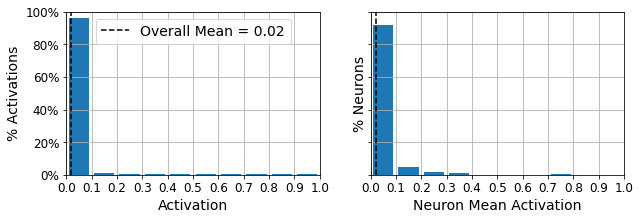

In [48]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

In [52]:
# 쿨백-라이블러 발산 
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [53]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
                                             keras.layers.Flatten(input_shape=[28, 28]),
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [============

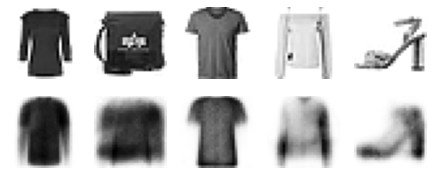

In [54]:
show_reconstructions(sparse_kl_ae)

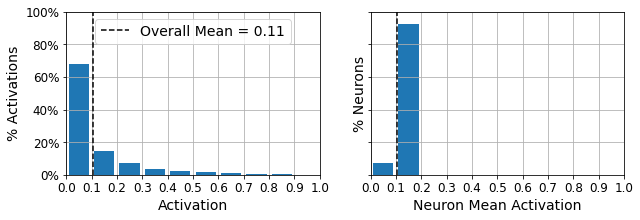

In [55]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

In [56]:
# 변이형 오토인코더 
  # 확률적 오토인코더, 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됨
  # 생성 오토인코더, 훈련 세트에서 샘플링된 것 같은 새로운 샘플을 생성할 수 있음
# 이런 두 속성때문에 RBM과 유사하게 만듦 
# 효율적인 근사 베이즈 추론 방법인 변분 베이즈 추론 수행

In [57]:
# 생성적 적대 신경망
# 신경망을 서로 겨루게 해서 경쟁을 통해 신경망을 향상하는 것을 기대
# GAN은 신경망 두개로 구성됨
  # 생성자 : 랜덤한 분포를 입력으로 받고 이미지와 같은 데이터를 출력, 랜덤한 입력은 생성할 이미지의 잠재 표현(즉 코딩)이라고 생각할 수 있음
  # 변이형 인코더의 디코더와 같은 기능 제공
  # 판별자 : 생성자에서 얻은 가짜 이미지나 훈련 세트에서 추출한 진짜 이미지를 입력으로 받아 입력된 이미지가 가짜인지 진짜인지 구분
# 첫번째 단계 - 판별자를 훈련
#            훈련 세트에서 실제 이미지 배치를 샘플링하고 생성한 동일한 수의 가짜 이미지를 합친다.
#            가짜 이미지의 레이블은 0, 진짜 이미지는 1
# 두번째 단계 - 생성자를 훈련
#            생성자를 사용해 다른 가짜 이미지 배치를 만듦, 다시 판별자를 사용해 이미지가 진짜인지 가짜인지 판별


In [58]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
                                     keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
                                     keras.layers.Dense(150, activation="selu"),
                                     keras.layers.Dense(28 * 28, activation="sigmoid"),
                                     keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
                                         keras.layers.Flatten(input_shape=[28, 28]),
                                         keras.layers.Dense(150, activation="selu"),
                                         keras.layers.Dense(100, activation="selu"),
                                         keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [60]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [61]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [62]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                  

In [64]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Epoch 1/1


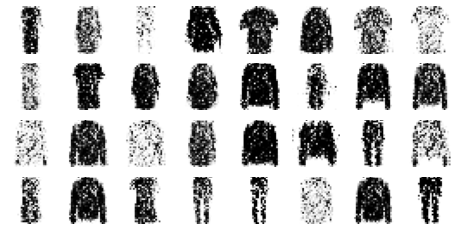

In [65]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
# GAN 훈련의 어려움